<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/v0.0.3/examples/gpax_viDKL_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep kernel learning for data reconstruction and automated experiment
This notebook demonstrates how to use a deep kernel learning with variational inference (viDKL) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (January 2022)*

Installations:

In [2]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax@v0.0.3
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

     |████████████████████████████████| 283 kB 4.1 MB/s 
     |████████████████████████████████| 287 kB 46.9 MB/s 
     |████████████████████████████████| 146 kB 3.2 MB/s 
     |████████████████████████████████| 193 kB 30.3 MB/s 
     |████████████████████████████████| 310 kB 60.4 MB/s 
     |████████████████████████████████| 865 kB 61.0 MB/s 


Imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

Download training data:

In [4]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [5]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [6]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [7]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

/usr/local/lib/python3.7/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 93))

Normalize data:

In [8]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.2826059331244979


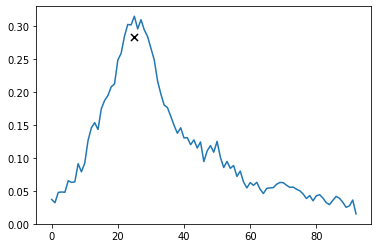

In [9]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [10]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

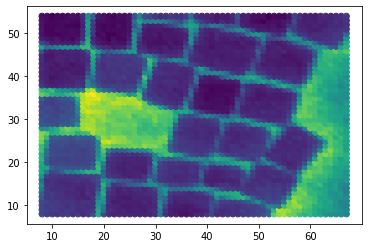

In [11]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [12]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Train:

In [13]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X, y, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:07<00:00, 13.40it/s, init loss: 23205.6149, avg. loss [96-100]: 15888.3928]



Inferred GP kernel parameters
k_length         [18.8629  9.8054]
k_scale          0.1381
noise            0.0103


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [14]:
mean, var = dkl.predict(key2, X)

Text(0.5, 1.0, 'DKL uncertainty')

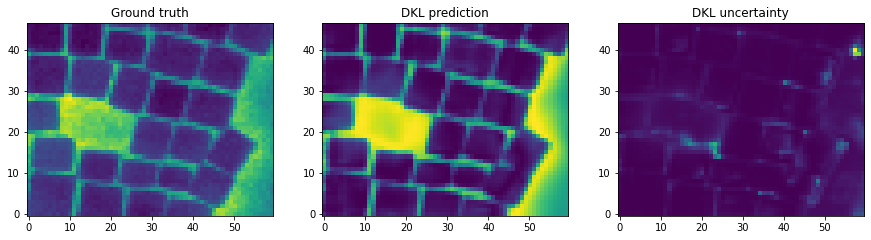

In [15]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

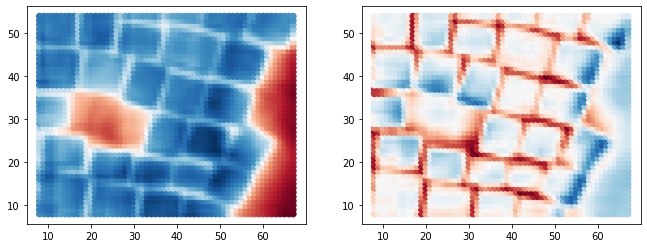

In [16]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [17]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [18]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:06<00:00, 16.59it/s, init loss: 21019.9002, avg. loss [96-100]: 18490.7111]


Inferred GP kernel parameters
k_length         [22.2339 16.9952]
k_scale          0.1507
noise            0.0119


In [19]:
mean, var = dkl.predict(key2, X)

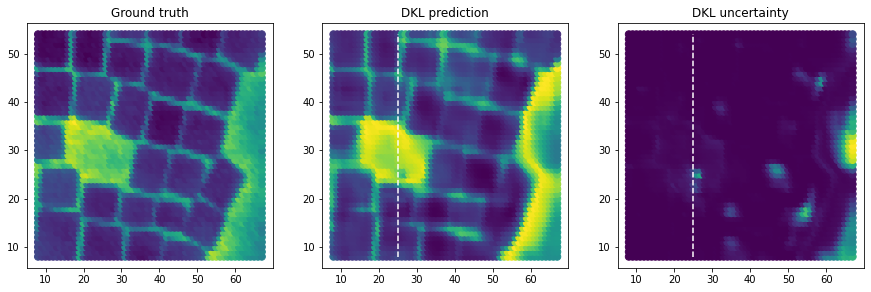

In [20]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just a few "measured" points:

In [21]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

In [43]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_train)

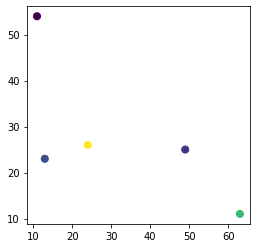

In [44]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/40


100%|██████████| 100/100 [00:01<00:00, 56.12it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


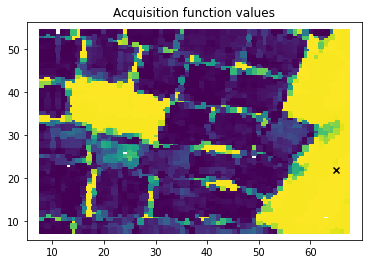

2/40


100%|██████████| 100/100 [00:01<00:00, 54.83it/s, init loss: 20125.9706, avg. loss [96-100]: 19061.8815]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3135
noise            0.12940000000000002


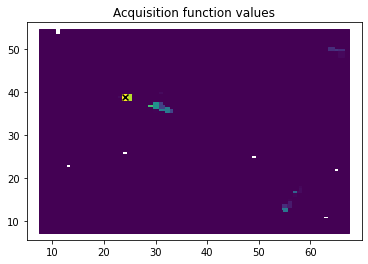

3/40


100%|██████████| 100/100 [00:01<00:00, 56.17it/s, init loss: 20127.2217, avg. loss [96-100]: 19061.9581]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30410000000000004
noise            0.11470000000000001


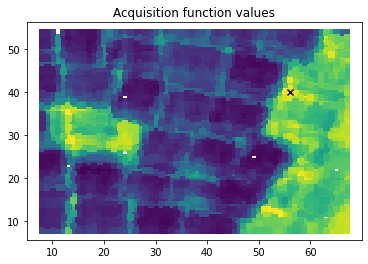

4/40


100%|██████████| 100/100 [00:01<00:00, 54.34it/s, init loss: 20128.4775, avg. loss [96-100]: 19061.9043]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2969
noise            0.10250000000000001


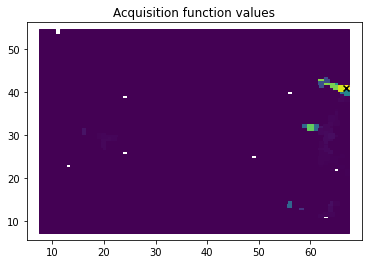

5/40


100%|██████████| 100/100 [00:01<00:00, 53.65it/s, init loss: 20129.8032, avg. loss [96-100]: 19061.8481]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3027
noise            0.0922


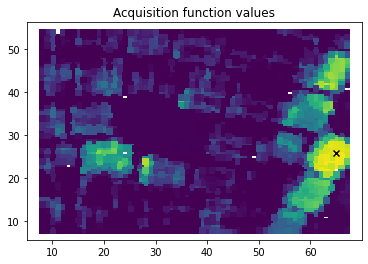

6/40


100%|██████████| 100/100 [00:01<00:00, 51.69it/s, init loss: 20131.0593, avg. loss [96-100]: 19061.8685]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30970000000000003
noise            0.0862


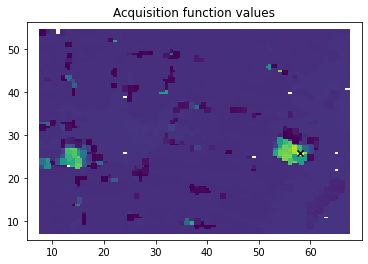

7/40


100%|██████████| 100/100 [00:01<00:00, 54.15it/s, init loss: 20132.3208, avg. loss [96-100]: 19061.7580]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3042
noise            0.0806


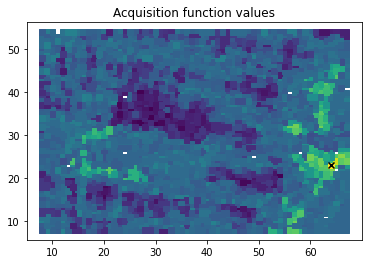

8/40


100%|██████████| 100/100 [00:02<00:00, 48.72it/s, init loss: 20133.7329, avg. loss [96-100]: 19062.3121]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3145
noise            0.0855


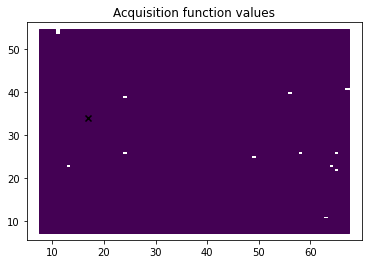

9/40


100%|██████████| 100/100 [00:01<00:00, 52.98it/s, init loss: 20135.0701, avg. loss [96-100]: 19063.1053]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3261
noise            0.0935


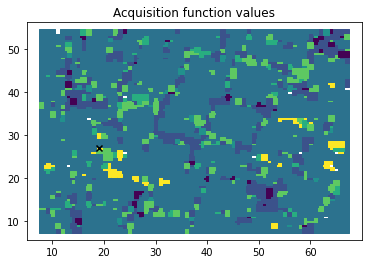

10/40


100%|██████████| 100/100 [00:02<00:00, 41.36it/s, init loss: 20136.4550, avg. loss [96-100]: 19063.3254]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33390000000000003
noise            0.0927


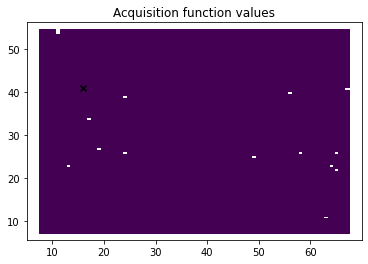

11/40


100%|██████████| 100/100 [00:01<00:00, 53.53it/s, init loss: 20137.7078, avg. loss [96-100]: 19063.5767]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32630000000000003
noise            0.093


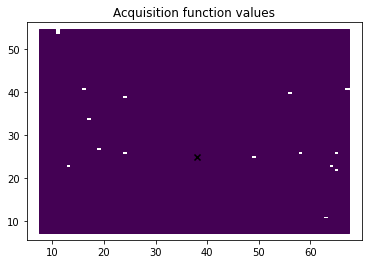

12/40


100%|██████████| 100/100 [00:02<00:00, 48.26it/s, init loss: 20138.9685, avg. loss [96-100]: 19063.6311]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3209
noise            0.0906


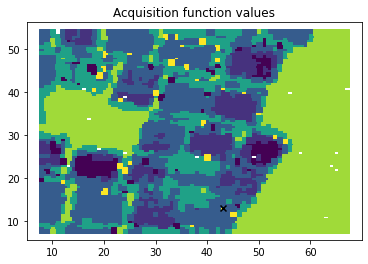

13/40


100%|██████████| 100/100 [00:01<00:00, 50.15it/s, init loss: 20140.1970, avg. loss [96-100]: 19063.4657]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32370000000000004
noise            0.0857


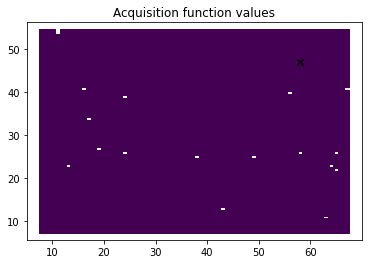

14/40


100%|██████████| 100/100 [00:01<00:00, 50.25it/s, init loss: 20141.3523, avg. loss [96-100]: 19063.4287]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31930000000000003
noise            0.08360000000000001


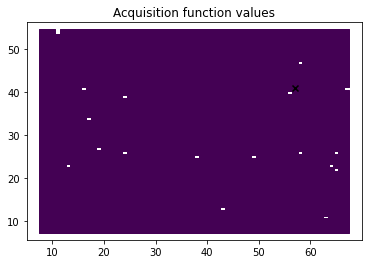

15/40


100%|██████████| 100/100 [00:01<00:00, 50.51it/s, init loss: 20142.6071, avg. loss [96-100]: 19063.4957]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3148
noise            0.0825


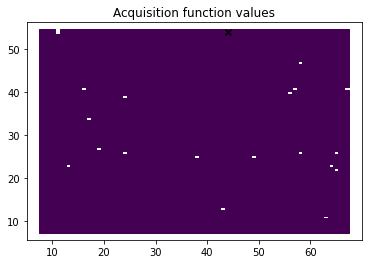

16/40


100%|██████████| 100/100 [00:03<00:00, 32.67it/s, init loss: 20143.8595, avg. loss [96-100]: 19063.6021]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31010000000000004
noise            0.082


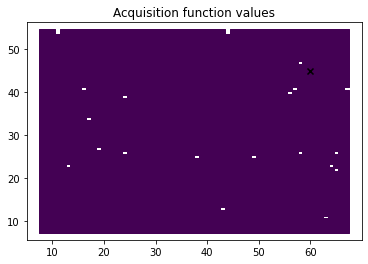

17/40


100%|██████████| 100/100 [00:02<00:00, 48.87it/s, init loss: 20145.1169, avg. loss [96-100]: 19063.5768]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30670000000000003
noise            0.08030000000000001


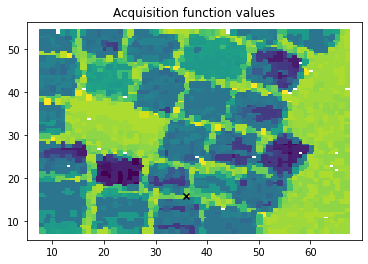

18/40


100%|██████████| 100/100 [00:02<00:00, 46.27it/s, init loss: 20146.3089, avg. loss [96-100]: 19063.4991]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3039
noise            0.07830000000000001


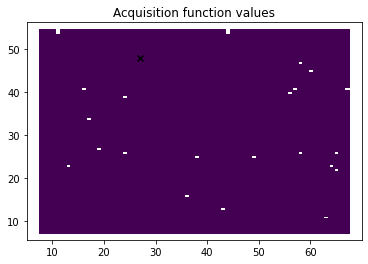

19/40


100%|██████████| 100/100 [00:02<00:00, 48.11it/s, init loss: 20147.5102, avg. loss [96-100]: 19063.3688]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.301
noise            0.07640000000000001


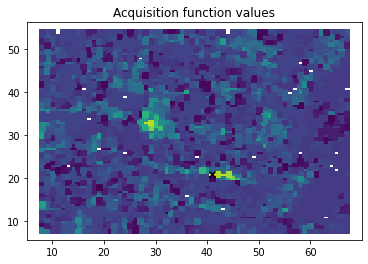

20/40


100%|██████████| 100/100 [00:02<00:00, 43.97it/s, init loss: 20148.8402, avg. loss [96-100]: 19063.1784]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3034
noise            0.0741


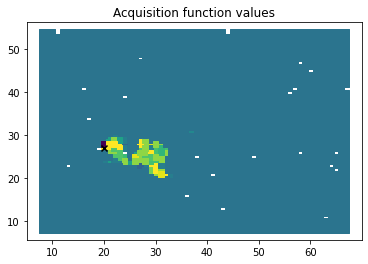

21/40


100%|██████████| 100/100 [00:02<00:00, 39.69it/s, init loss: 20150.1874, avg. loss [96-100]: 19063.6710]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30820000000000003
noise            0.0762


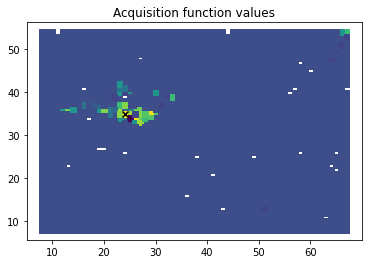

22/40


100%|██████████| 100/100 [00:02<00:00, 45.45it/s, init loss: 20151.6148, avg. loss [96-100]: 19084.1516]



Inferred GP kernel parameters
k_length         [1.8942 1.6148]
k_scale          0.2373
noise            0.0409


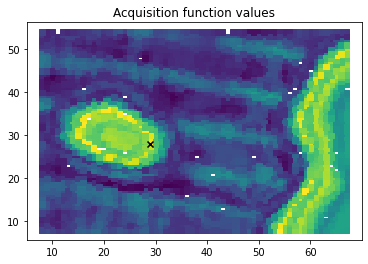

23/40


100%|██████████| 100/100 [00:02<00:00, 47.34it/s, init loss: 20152.9837, avg. loss [96-100]: 19064.3903]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3164
noise            0.0787


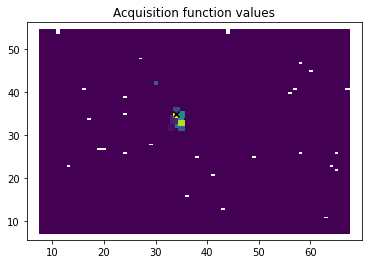

24/40


100%|██████████| 100/100 [00:02<00:00, 41.25it/s, init loss: 20154.2153, avg. loss [96-100]: 19064.4268]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3135
noise            0.078


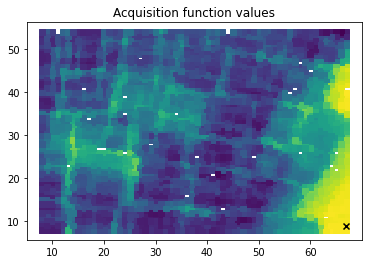

25/40


100%|██████████| 100/100 [00:02<00:00, 46.56it/s, init loss: 20155.4963, avg. loss [96-100]: 19126.3625]



Inferred GP kernel parameters
k_length         [2.6704 3.1372]
k_scale          0.193
noise            0.0362


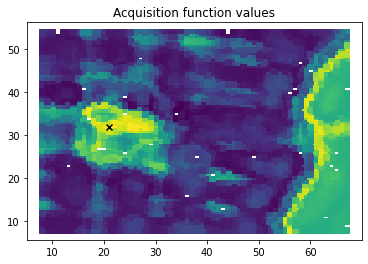

26/40


100%|██████████| 100/100 [00:02<00:00, 44.46it/s, init loss: 20156.7983, avg. loss [96-100]: 19095.9202]



Inferred GP kernel parameters
k_length         [2.3878 2.7271]
k_scale          0.20770000000000002
noise            0.035500000000000004


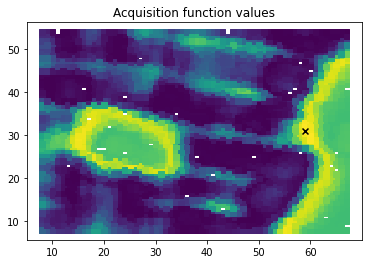

27/40


100%|██████████| 100/100 [00:02<00:00, 45.52it/s, init loss: 20158.1148, avg. loss [96-100]: 19083.6889]



Inferred GP kernel parameters
k_length         [2.4112 3.0269]
k_scale          0.2039
noise            0.0346


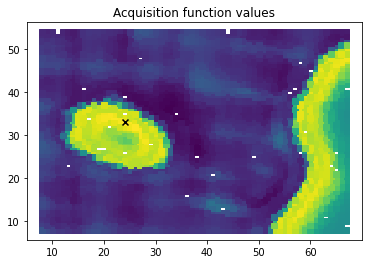

28/40


100%|██████████| 100/100 [00:02<00:00, 48.32it/s, init loss: 20159.3286, avg. loss [96-100]: 19108.4350]



Inferred GP kernel parameters
k_length         [2.7751 2.825 ]
k_scale          0.2328
noise            0.037200000000000004


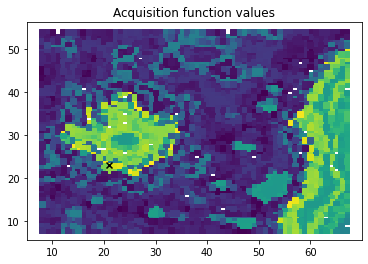

29/40


100%|██████████| 100/100 [00:02<00:00, 48.55it/s, init loss: 20160.5807, avg. loss [96-100]: 19064.7089]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32480000000000003
noise            0.0755


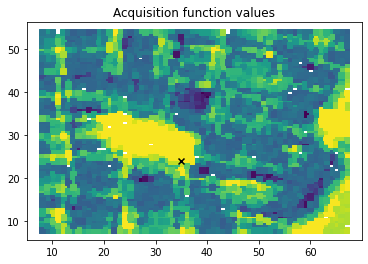

30/40


100%|██████████| 100/100 [00:01<00:00, 51.10it/s, init loss: 20161.8431, avg. loss [96-100]: 19064.6489]



Inferred GP kernel parameters
k_length         [0.3679 0.368 ]
k_scale          0.3225
noise            0.0746


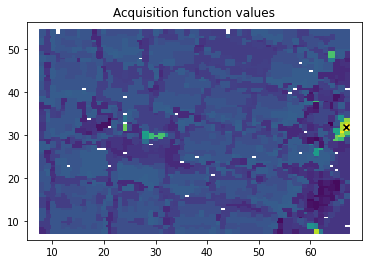

31/40


100%|██████████| 100/100 [00:01<00:00, 53.83it/s, init loss: 20163.0723, avg. loss [96-100]: 19079.2283]



Inferred GP kernel parameters
k_length         [4.7739 2.6275]
k_scale          0.1917
noise            0.027800000000000002


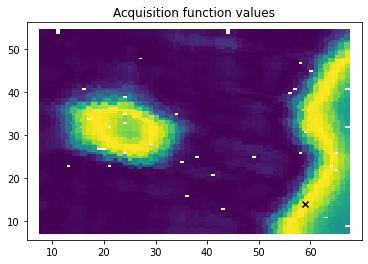

32/40


100%|██████████| 100/100 [00:02<00:00, 40.75it/s, init loss: 20164.4580, avg. loss [96-100]: 19088.2887]



Inferred GP kernel parameters
k_length         [2.5659 3.0028]
k_scale          0.2232
noise            0.0322


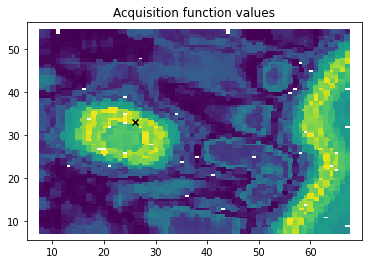

33/40


100%|██████████| 100/100 [00:01<00:00, 52.32it/s, init loss: 20165.7907, avg. loss [96-100]: 19063.9082]



Inferred GP kernel parameters
k_length         [2.1537 3.0354]
k_scale          0.2323
noise            0.027600000000000003


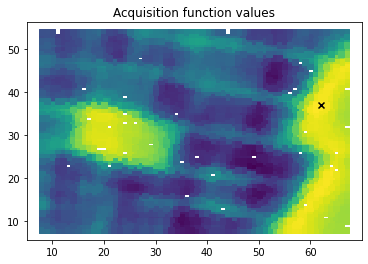

34/40


100%|██████████| 100/100 [00:01<00:00, 51.51it/s, init loss: 20167.1301, avg. loss [96-100]: 19064.4138]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3307
noise            0.07150000000000001


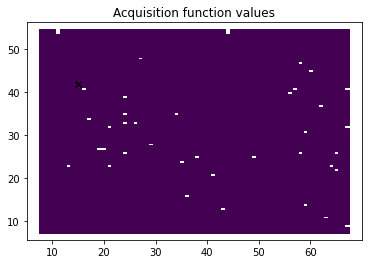

35/40


100%|██████████| 100/100 [00:01<00:00, 54.20it/s, init loss: 20168.3543, avg. loss [96-100]: 19120.7383]



Inferred GP kernel parameters
k_length         [3.1838 3.9592]
k_scale          0.22260000000000002
noise            0.0292


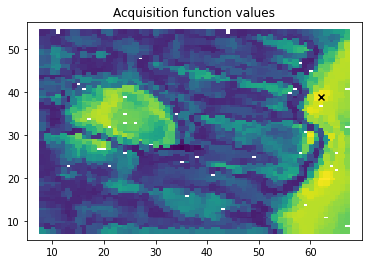

36/40


100%|██████████| 100/100 [00:01<00:00, 51.08it/s, init loss: 20169.6031, avg. loss [96-100]: 19064.4994]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33
noise            0.07100000000000001


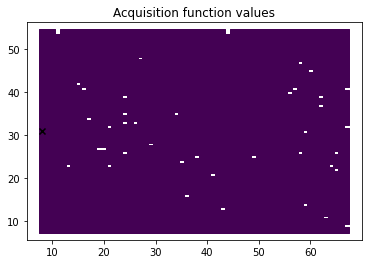

37/40


100%|██████████| 100/100 [00:01<00:00, 53.77it/s, init loss: 20170.8745, avg. loss [96-100]: 19094.4372]



Inferred GP kernel parameters
k_length         [3.6472 4.2899]
k_scale          0.1998
noise            0.028300000000000002


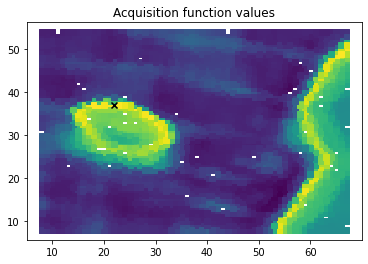

38/40


100%|██████████| 100/100 [00:02<00:00, 40.26it/s, init loss: 20172.1155, avg. loss [96-100]: 19061.3010]



Inferred GP kernel parameters
k_length         [2.771  2.1941]
k_scale          0.21380000000000002
noise            0.022600000000000002


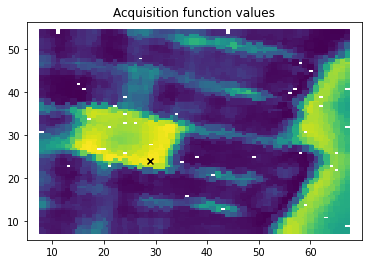

39/40


100%|██████████| 100/100 [00:01<00:00, 52.86it/s, init loss: 20173.5273, avg. loss [96-100]: 19081.0566]



Inferred GP kernel parameters
k_length         [4.4446 4.4548]
k_scale          0.1885
noise            0.027600000000000003


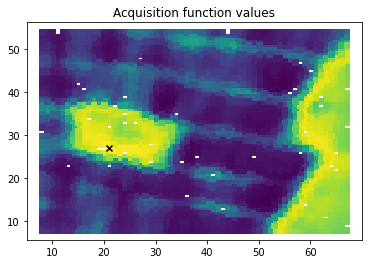

40/40


100%|██████████| 100/100 [00:01<00:00, 50.77it/s, init loss: 20174.7008, avg. loss [96-100]: 19116.0024]



Inferred GP kernel parameters
k_length         [4.7488 5.0898]
k_scale          0.2242
noise            0.0308


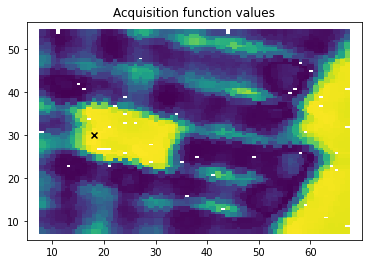

In [45]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 40

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_test, beta=4, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

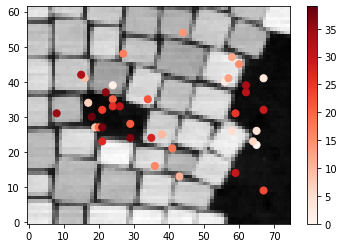

In [46]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

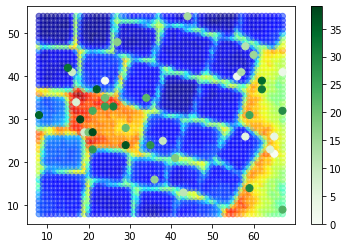

In [47]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of intetest is maximized.